# Klasyfikacja przy pomocy klasyfikatora KNN

## Zaimportowoanie bibliotek

In [1]:
from src.extraction import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import SelectFromModel

## Funkcja do pozyskiwania zbiorów uczących oraz testowych
Podział próbek tak jak w przypadku klasyfikatora drzewa decyzyjnego na 25 \% próbek w zbiorze uczącym oraz 75 \% próbek w zbiorze testowym. Próbki zostały podzielone w taki sposób, żeby dla unikalnej klasy przypadały procenty podziałów próbek.

In [2]:
def get_sets(X, y):
    """ Autor: Aleksandra """
    idx = np.arange(0, len(X))
    ind_train = np.where(((idx + 1) % 4) != 0)
    ind_test = np.where(((idx + 1) % 4) == 0)
    X_train = X[ind_train]
    y_train_enc = y[ind_train]
    X_test = X[ind_test]
    y_test_enc = y[ind_test]

    return X_train, X_test, y_train_enc, y_test_enc

## Badanie

W badaniu wykorzystano funkcje zaimplementowane w celu ekstrakcji cech. Wyektrahowane zostały dodawane do ramki danych z biblioteki **Pandas**. Uzyskane dane zostały posortowane według współgłosek w celu łatwiejszego podziału zbioru na zbiór uczący oraz testowy dla klasyfikatora KNN. 

In [3]:
df = create_database().sort_values('vowel')

In [4]:
df

,vowel,sex,f0,form1,form2,form3,form4,spc1,spc2,spc3,entrspc
0,a,1,204.081633,315.948936,1263.413590,1276.537740,2647.008730,0.000000,0.043574,0.198995,3.815404
64,a,0,158.730159,0.000000,0.000000,625.723402,1252.624817,0.000000,0.124924,0.603017,2.787091
65,a,0,147.058824,0.000000,0.000000,585.885056,1224.867304,0.000000,0.230040,0.464162,3.804804
66,a,0,147.058824,57.147870,547.790667,1226.394104,2741.215155,0.325853,0.356340,0.488478,3.812406
67,a,0,142.857143,250.250064,896.375921,1150.711714,2714.955427,0.356370,0.628263,1.000000,3.688920
...,...,...,...,...,...,...,...,...,...,...,...
52,y,1,188.679245,277.199163,486.697745,2137.913104,2959.066737,0.023442,0.043694,0.148104,2.406425
51,y,1,188.679245,301.555272,450.490850,2115.201333,2966.392632,0.173376,0.116756,0.082141,2.464107
50,y,1,204.081633,0.000000,382.441336,1434.444630,2183.091206,0.303255,0.241388,0.154546,2.341790
118,y,0,138.888889,235.339449,525.554358,1440.605228,2544.053450,0.537042,0.622504,0.970082,3.109960


In [5]:
X = df.iloc[:, 3:].to_numpy()
y = df.iloc[:, 0].to_numpy()
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [6]:
X_train, X_test, y_train_enc, y_test_enc = get_sets(X, y)

## Ustalenie ważności poszczególnych cech

W celu ustalenia wag poszczególnych cech wykorzystano algorytm boostingowy AdaBoost w formie regresora. Algorytm ten można przedstawić w następujących krokachh [1]:

1. Dopasowanie regresora do oryginalnego zestawu danych
2. Dopasowanie kopii regresora do tego samego zestawu danych
3. Dopasowanie wag wystąpień zgodnie z błędem aktualnej prognozy

Algorytm AdaBoostRegressor pozyskano z biblioteki sklearn z pakietu ensemble. Liczbę estymatorów ustalono arbitralnie jako 100. 

In [7]:
regr = AdaBoostRegressor(n_estimators=100)
regr = regr.fit(X, y)

In [8]:
model = SelectFromModel(regr, prefit=True)
X = model.transform(X)

In [9]:
print("Wagi poszczególnych cech:")
print(regr.feature_importances_)

Wagi poszczególnych cech:
[0.05759978 0.19608382 0.17057762 0.12162683 0.07402954 0.07592335
 0.08184199 0.22231707]


## Klasyfikacja za pomocą metody najbliższych sąsiadów

Klasyfikację wykonano metodą najbliższych sąsiadów, która jak sama nazwa wskazuje bazuje na odległości od poszczególnych próbek w celu zaliczenia ich do danej klasy. Uczenie nastąpiło na wybranym zbiorze uczącym, natomiast predykcja na wybranym zbiorze testowym. W celu uzyskania klas poszczególnych próbek wykorzystano enkoder. Wyniki przedstawiono przy pomocy macierzy konfuzji oraz metryki dokładności.

In [11]:
y_test = le.inverse_transform(y_test_enc)

In [12]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train_enc)
y_pred = clf.predict(X_test)

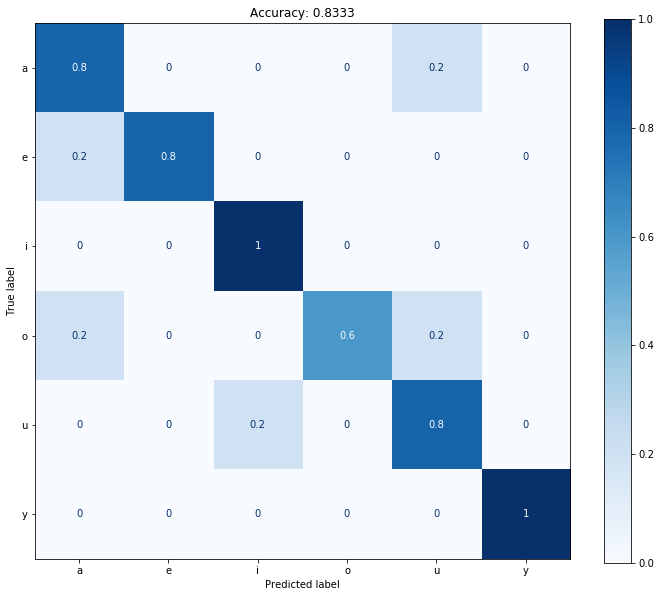

In [19]:
fig, ax = plt.subplots(figsize=(12,10))
plot_confusion_matrix(clf, X_test, y_test_enc, display_labels=np.unique(y_test), ax=ax, normalize='true', cmap='Blues')
plt.title(f'Accuracy: {accuracy_score(y_test_enc, y_pred):.4f}')
plt.show()

## Wnioski

Uzyskane wyniki świadczą o akceptowalnej dokładności klasyfikatora. Najwięcej próbek poprawnych zostało zaklasyfikowanych dla samogłoski *y*. Najmniej natomiast zostało dobrze zaklasyfikowanych dla klasy *o*. Dokładność klasyfikacji algorymtu najbliższego sąsiada wyniosła 0.8333.

## Bibliografia

[1] Y. Freund, R. Schapire, “A Decision-Theoretic Generalization of on-Line Learning and an Application to Boosting”, 1995